In [1]:
import numpy as np 
import pandas as pd
import lightgbm as lgb
from numpy.random import normal, seed
import math
from sklearn.metrics import mean_squared_error

from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib import pyplot
from pylab import rcParams
from plotly import tools
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import norm
import scipy.stats as scs

from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
df = pd.read_excel('/content/training.xls')

In [3]:
df['time'] = pd.to_datetime(df['time'])

In [4]:
df.set_index(df['time'],inplace = True)

In [5]:
df.head()

,time,open,high,low,close,EMA,Upper,Lower,ATR,RSI,MACD,Signal,K,D
time,,,,,,,,,,,,,,
2015-01-01 03:45:00+00:00,2015-01-01 03:45:00+00:00,8272.7998,8294.7002,8248.7500,8284.0000,8251.963225,8533.127833,8015.157227,87.033773,50.353163,-23.606922,-26.724647,91.629904,85.654156
2015-01-02 03:45:00+00:00,2015-01-02 03:45:00+00:00,8288.7002,8410.5996,8288.7002,8395.4502,8280.660620,8495.653994,8035.736046,89.859903,57.698911,-10.702293,-23.520176,96.774533,92.081321
2015-01-05 03:45:00+00:00,2015-01-05 03:45:00+00:00,8407.9502,8445.5996,8363.9004,8378.4004,8300.208576,8458.456815,8056.943285,89.276996,56.325895,-1.829964,-19.182134,96.904672,95.103036
2015-01-06 03:45:00+00:00,2015-01-06 03:45:00+00:00,8325.2998,8327.8496,8111.3501,8127.3501,8265.636881,8432.458119,8051.851991,101.975089,40.894657,-14.884659,-18.322639,79.484990,91.054732
2015-01-07 03:45:00+00:00,2015-01-07 03:45:00+00:00,8118.6499,8151.2002,8065.4502,8102.1001,8232.929525,8424.201350,8036.248750,100.816154,39.716116,-26.957315,-20.049574,46.151656,74.180439


In [6]:
df.head()

,time,open,high,low,close,EMA,Upper,Lower,ATR,RSI,MACD,Signal,K,D
time,,,,,,,,,,,,,,
2015-01-01 03:45:00+00:00,2015-01-01 03:45:00+00:00,8272.7998,8294.7002,8248.7500,8284.0000,8251.963225,8533.127833,8015.157227,87.033773,50.353163,-23.606922,-26.724647,91.629904,85.654156
2015-01-02 03:45:00+00:00,2015-01-02 03:45:00+00:00,8288.7002,8410.5996,8288.7002,8395.4502,8280.660620,8495.653994,8035.736046,89.859903,57.698911,-10.702293,-23.520176,96.774533,92.081321
2015-01-05 03:45:00+00:00,2015-01-05 03:45:00+00:00,8407.9502,8445.5996,8363.9004,8378.4004,8300.208576,8458.456815,8056.943285,89.276996,56.325895,-1.829964,-19.182134,96.904672,95.103036
2015-01-06 03:45:00+00:00,2015-01-06 03:45:00+00:00,8325.2998,8327.8496,8111.3501,8127.3501,8265.636881,8432.458119,8051.851991,101.975089,40.894657,-14.884659,-18.322639,79.484990,91.054732
2015-01-07 03:45:00+00:00,2015-01-07 03:45:00+00:00,8118.6499,8151.2002,8065.4502,8102.1001,8232.929525,8424.201350,8036.248750,100.816154,39.716116,-26.957315,-20.049574,46.151656,74.180439


In [7]:
#Exploring the data

In [8]:
df.shape

(1646, 14)

In [9]:
# for feature in df.columns:
#     print("{} : {}".format(feature,df[feature].isna().sum()))
df.isna().sum()

time      0
open      0
high      0
low       0
close     0
EMA       0
Upper     0
Lower     0
ATR       0
RSI       0
MACD      0
Signal    0
K         0
D         0
dtype: int64

In [10]:
# visualizing trends in stock prices


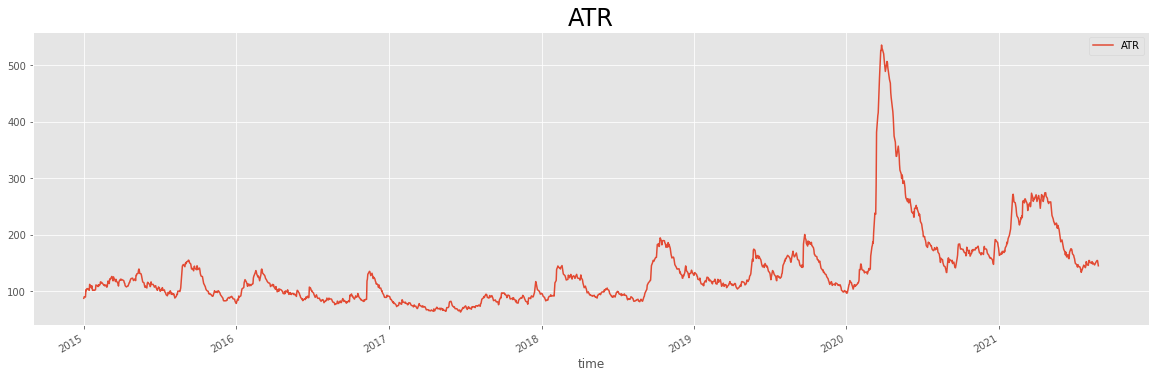

In [11]:
ax = df[['ATR']].plot(figsize=(20, 6))
ax.set_title('ATR', fontsize=24);

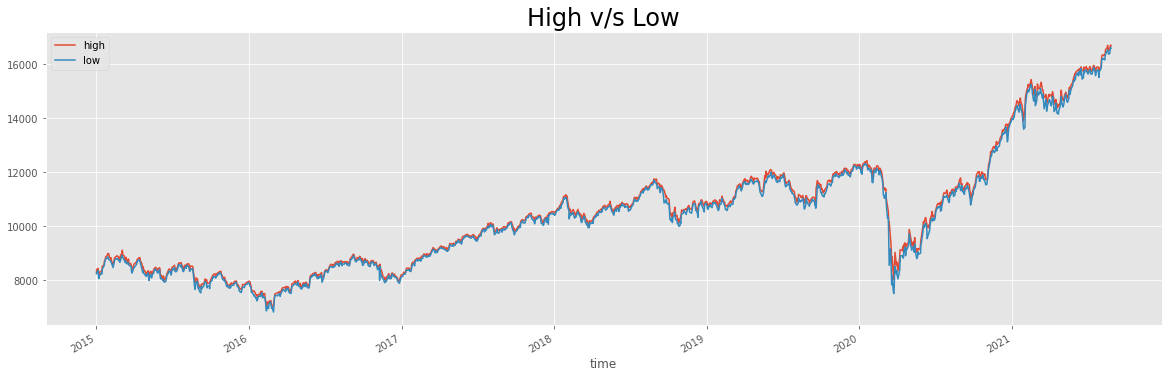

In [12]:
ax = df[['high', 'low']].plot(figsize=(20, 6))
ax.set_title('High v/s Low', fontsize=24);

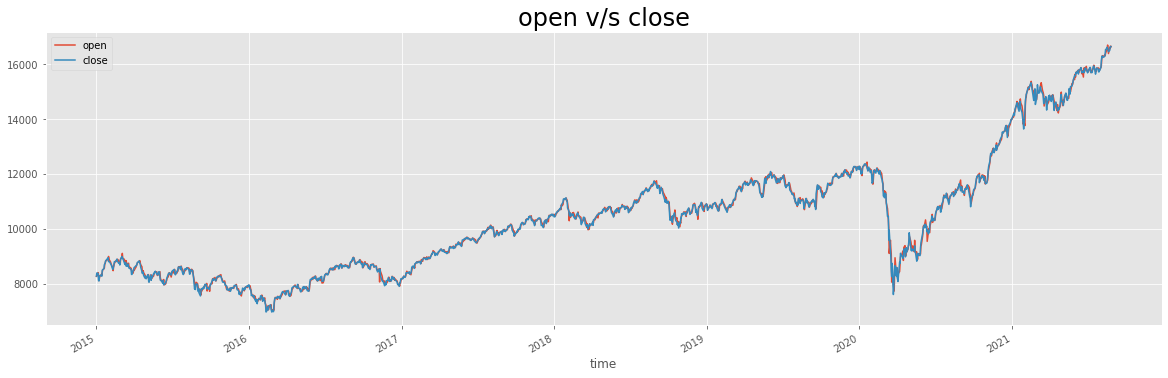

In [13]:
ax = df[['open', 'close']].plot(figsize=(20, 6))
ax.set_title('open v/s close', fontsize=24);

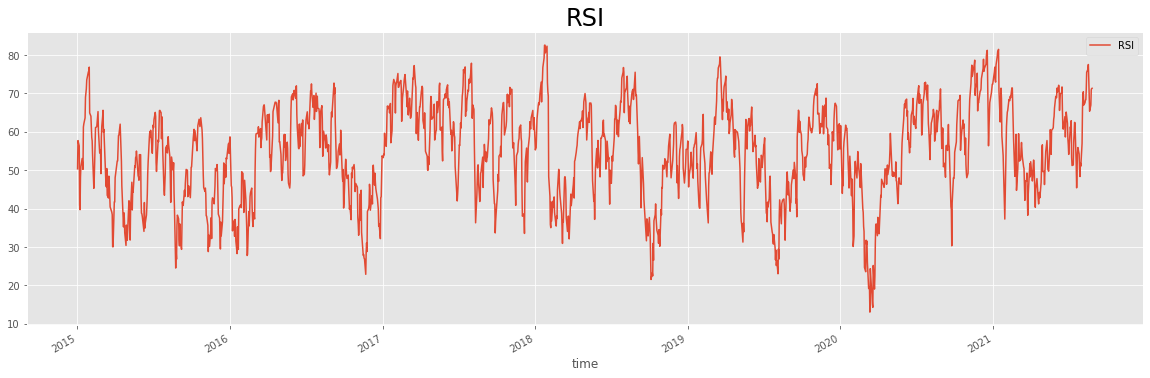

In [14]:
ax = df[['RSI']].plot(figsize=(20, 6))
ax.set_title('RSI', fontsize=24);

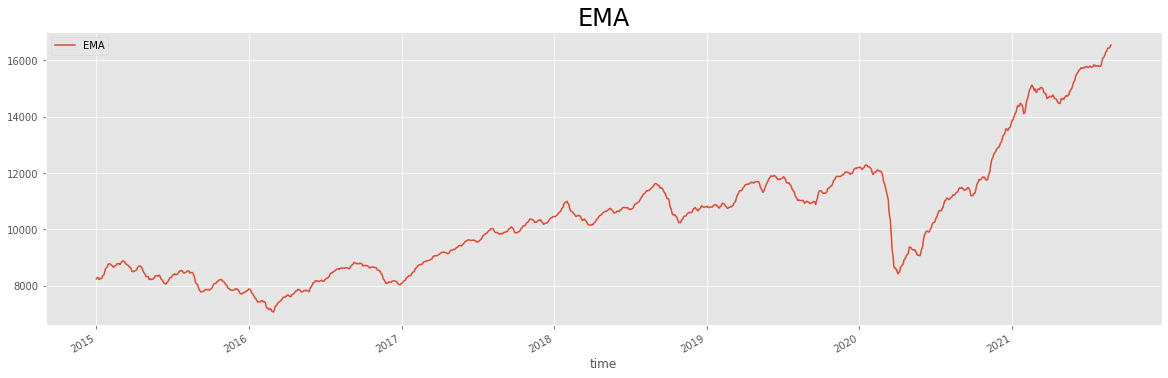

In [15]:
ax = df[['EMA']].plot(figsize=(20, 6))
ax.set_title('EMA', fontsize=24);

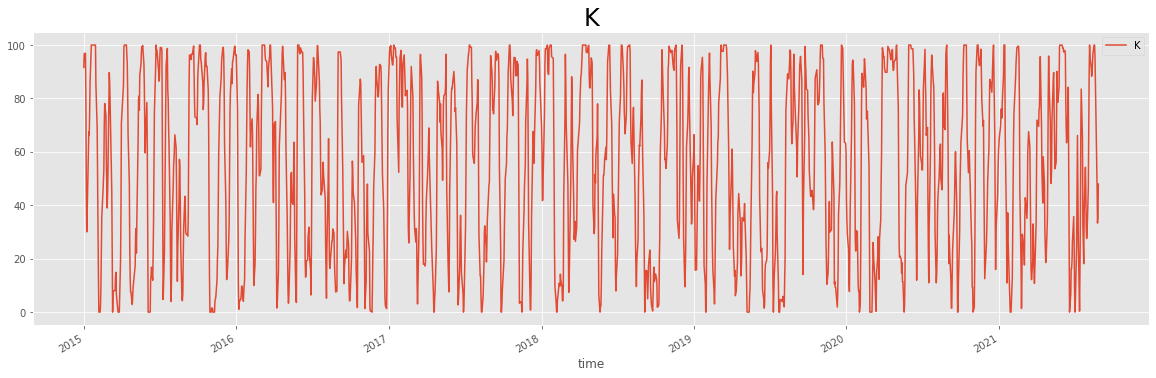

In [16]:
ax = df[['K']].plot(figsize=(20, 6))
ax.set_title('K', fontsize=24);

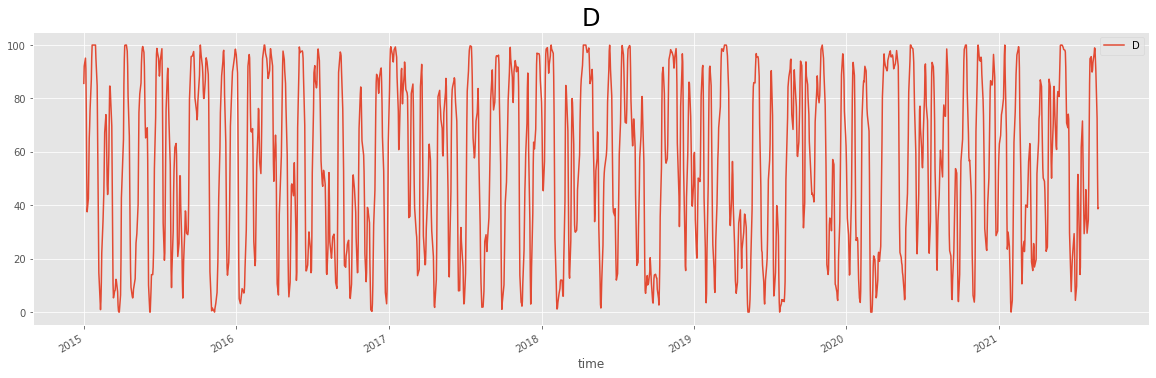

In [17]:
ax = df[['D']].plot(figsize=(20, 6))
ax.set_title('D', fontsize=24);

In [20]:
data = df[['time','open','high','low','close','ATR','RSI','EMA','K','D']]

In [21]:
data

,time,open,high,low,close,ATR,RSI,EMA,K,D
time,,,,,,,,,,
2015-01-01 03:45:00+00:00,2015-01-01 03:45:00+00:00,8272.7998,8294.7002,8248.7500,8284.0000,87.033773,50.353163,8251.963225,91.629904,85.654156
2015-01-02 03:45:00+00:00,2015-01-02 03:45:00+00:00,8288.7002,8410.5996,8288.7002,8395.4502,89.859903,57.698911,8280.660620,96.774533,92.081321
2015-01-05 03:45:00+00:00,2015-01-05 03:45:00+00:00,8407.9502,8445.5996,8363.9004,8378.4004,89.276996,56.325895,8300.208576,96.904672,95.103036
2015-01-06 03:45:00+00:00,2015-01-06 03:45:00+00:00,8325.2998,8327.8496,8111.3501,8127.3501,101.975089,40.894657,8265.636881,79.484990,91.054732
2015-01-07 03:45:00+00:00,2015-01-07 03:45:00+00:00,8118.6499,8151.2002,8065.4502,8102.1001,100.816154,39.716116,8232.929525,46.151656,74.180439
...,...,...,...,...,...,...,...,...,...,...
2021-08-20 03:45:00+00:00,2021-08-20 03:45:00+00:00,16382.5000,16509.5510,16376.0500,16450.5000,150.770560,65.356885,16427.664426,75.684988,90.370522
2021-08-23 03:45:00+00:00,2021-08-23 03:45:00+00:00,16592.2500,16592.5000,16395.6990,16496.4490,154.058449,66.952470,16441.421341,46.723656,72.611741
2021-08-24 03:45:00+00:00,2021-08-24 03:45:00+00:00,16561.4000,16647.1000,16495.3010,16624.6000,153.897060,70.968550,16478.057073,33.340055,51.916233


Text(0.5, 1.0, 'Yearly stock market')

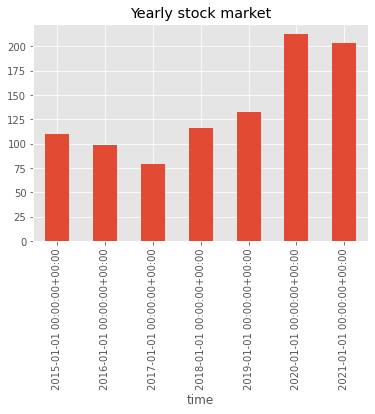

In [23]:
df['ATR'].resample('AS').mean().plot(kind='bar')
plt.title('Yearly stock market')

In [25]:
df_train = data.loc[:'2020']
df_valid = data.loc['2020':]

In [26]:
df_train

,time,open,high,low,close,ATR,RSI,EMA,K,D
time,,,,,,,,,,
2015-01-01 03:45:00+00:00,2015-01-01 03:45:00+00:00,8272.7998,8294.7002,8248.7500,8284.0000,87.033773,50.353163,8251.963225,91.629904,85.654156
2015-01-02 03:45:00+00:00,2015-01-02 03:45:00+00:00,8288.7002,8410.5996,8288.7002,8395.4502,89.859903,57.698911,8280.660620,96.774533,92.081321
2015-01-05 03:45:00+00:00,2015-01-05 03:45:00+00:00,8407.9502,8445.5996,8363.9004,8378.4004,89.276996,56.325895,8300.208576,96.904672,95.103036
2015-01-06 03:45:00+00:00,2015-01-06 03:45:00+00:00,8325.2998,8327.8496,8111.3501,8127.3501,101.975089,40.894657,8265.636881,79.484990,91.054732
2015-01-07 03:45:00+00:00,2015-01-07 03:45:00+00:00,8118.6499,8151.2002,8065.4502,8102.1001,100.816154,39.716116,8232.929525,46.151656,74.180439
...,...,...,...,...,...,...,...,...,...,...
2020-12-24 03:45:00+00:00,2020-12-24 03:45:00+00:00,13672.1500,13771.7500,13626.9000,13749.2500,189.371000,67.601612,13573.149224,31.033209,28.631803
2020-12-28 03:45:00+00:00,2020-12-28 03:45:00+00:00,13815.1500,13885.3000,13811.5500,13873.2000,185.562357,70.212593,13633.159379,44.039250,30.344093
2020-12-29 03:45:00+00:00,2020-12-29 03:45:00+00:00,13910.3500,13967.6000,13859.9000,13932.6000,180.000760,71.402027,13693.047503,53.818765,42.963741


In [27]:
df_valid

,time,open,high,low,close,ATR,RSI,EMA,K,D
time,,,,,,,,,,
2020-01-01 03:45:00+00:00,2020-01-01 03:45:00+00:00,12202.15,12222.200,12165.300,12182.500,96.200243,56.317156,12188.995166,41.759588,54.918316
2020-01-02 03:45:00+00:00,2020-01-02 03:45:00+00:00,12198.55,12289.900,12195.250,12282.200,97.000226,61.606181,12207.636133,34.155623,45.214801
2020-01-03 03:45:00+00:00,2020-01-03 03:45:00+00:00,12261.10,12265.600,12191.350,12226.650,96.560924,57.433604,12211.438906,29.356058,35.090423
2020-01-06 03:45:00+00:00,2020-01-06 03:45:00+00:00,12170.60,12179.100,11974.200,11993.050,107.695858,43.952223,12167.761125,23.175979,28.895886
2020-01-07 03:45:00+00:00,2020-01-07 03:45:00+00:00,12079.10,12152.150,12005.350,12052.950,111.367582,47.364068,12144.798900,10.705407,21.079148
...,...,...,...,...,...,...,...,...,...,...
2021-08-20 03:45:00+00:00,2021-08-20 03:45:00+00:00,16382.50,16509.551,16376.050,16450.500,150.770560,65.356885,16427.664426,75.684988,90.370522
2021-08-23 03:45:00+00:00,2021-08-23 03:45:00+00:00,16592.25,16592.500,16395.699,16496.449,154.058449,66.952470,16441.421341,46.723656,72.611741
2021-08-24 03:45:00+00:00,2021-08-24 03:45:00+00:00,16561.40,16647.100,16495.301,16624.600,153.897060,70.968550,16478.057073,33.340055,51.916233


In [28]:
df_train.drop('time',axis=1,inplace=True)

In [30]:
df_train

,open,high,low,close,ATR,RSI,EMA,K,D
time,,,,,,,,,
2015-01-01 03:45:00+00:00,8272.7998,8294.7002,8248.7500,8284.0000,87.033773,50.353163,8251.963225,91.629904,85.654156
2015-01-02 03:45:00+00:00,8288.7002,8410.5996,8288.7002,8395.4502,89.859903,57.698911,8280.660620,96.774533,92.081321
2015-01-05 03:45:00+00:00,8407.9502,8445.5996,8363.9004,8378.4004,89.276996,56.325895,8300.208576,96.904672,95.103036
2015-01-06 03:45:00+00:00,8325.2998,8327.8496,8111.3501,8127.3501,101.975089,40.894657,8265.636881,79.484990,91.054732
2015-01-07 03:45:00+00:00,8118.6499,8151.2002,8065.4502,8102.1001,100.816154,39.716116,8232.929525,46.151656,74.180439
...,...,...,...,...,...,...,...,...,...
2020-12-24 03:45:00+00:00,13672.1500,13771.7500,13626.9000,13749.2500,189.371000,67.601612,13573.149224,31.033209,28.631803
2020-12-28 03:45:00+00:00,13815.1500,13885.3000,13811.5500,13873.2000,185.562357,70.212593,13633.159379,44.039250,30.344093
2020-12-29 03:45:00+00:00,13910.3500,13967.6000,13859.9000,13932.6000,180.000760,71.402027,13693.047503,53.818765,42.963741


In [29]:
df_valid.drop('time',axis=1,inplace=True)

In [32]:
df.head()

,time,open,high,low,close,EMA,Upper,Lower,ATR,RSI,MACD,Signal,K,D
time,,,,,,,,,,,,,,
2015-01-01 03:45:00+00:00,2015-01-01 03:45:00+00:00,8272.7998,8294.7002,8248.7500,8284.0000,8251.963225,8533.127833,8015.157227,87.033773,50.353163,-23.606922,-26.724647,91.629904,85.654156
2015-01-02 03:45:00+00:00,2015-01-02 03:45:00+00:00,8288.7002,8410.5996,8288.7002,8395.4502,8280.660620,8495.653994,8035.736046,89.859903,57.698911,-10.702293,-23.520176,96.774533,92.081321
2015-01-05 03:45:00+00:00,2015-01-05 03:45:00+00:00,8407.9502,8445.5996,8363.9004,8378.4004,8300.208576,8458.456815,8056.943285,89.276996,56.325895,-1.829964,-19.182134,96.904672,95.103036
2015-01-06 03:45:00+00:00,2015-01-06 03:45:00+00:00,8325.2998,8327.8496,8111.3501,8127.3501,8265.636881,8432.458119,8051.851991,101.975089,40.894657,-14.884659,-18.322639,79.484990,91.054732
2015-01-07 03:45:00+00:00,2015-01-07 03:45:00+00:00,8118.6499,8151.2002,8065.4502,8102.1001,8232.929525,8424.201350,8036.248750,100.816154,39.716116,-26.957315,-20.049574,46.151656,74.180439
